In [169]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from feature_selectors import *

In [170]:
gebruikers_df = pd.read_csv(r'..\..\..\data\gebruikersinformatie.csv', delimiter = ';')
evenement_df = pd.read_csv(r'..\..\..\data\evenementinformatie.csv', delimiter = ';')
aanwezigheid_df = pd.read_csv(r'..\..\..\data\evenementaanwezigheid.csv', delimiter = ';')
bericht_df = pd.read_csv(r'..\..\..\data\berichtinteracties_met_sentiment.csv', delimiter = ';')

In [171]:
# df = merge_on_all(bericht_df, evenement_df, gebruikers_df, aanwezigheid_df)
df = merge_on_aanwezigheid(aanwezigheid_df, evenement_df, gebruikers_df)
# df = merge_on_bericht(bericht_df, evenement_df, gebruikers_df)

df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,e001,g123,bijgewoond,bbq,24-2-2023,g296,15-5-2023,11-12-2023,19.0,data engineering,eerstejaars,regulier
1,e001,g296,bijgewoond,bbq,24-2-2023,g296,6-9-2023,18-3-2024,22.0,security & cloud,eerstejaars,premium
2,e001,g032,geregistreerd,bbq,24-2-2023,g296,4-1-2023,19-5-2023,17.0,data engineering,tweedejaars,regulier
3,e001,g217,bijgewoond,bbq,24-2-2023,g296,13-8-2023,18-1-2024,24.0,data engineering,vierdejaars,regulier
4,e001,g162,geregistreerd,bbq,24-2-2023,g296,21-8-2023,8-5-2024,18.0,human computer interaction,tweedejaars,regulier
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,e040,g121,geregistreerd,workshop,19-2-2023,g215,15-10-2023,14-1-2024,24.0,human computer interaction,tweedejaars,premium
3428,e040,g170,afwezig,workshop,19-2-2023,g215,2-6-2023,2-6-2023,23.0,software engineering,derdejaars,premium
3429,e040,g141,bijgewoond,workshop,19-2-2023,g215,2-11-2023,18-4-2024,17.0,security & cloud,derdejaars,regulier
3430,e040,g176,geregistreerd,workshop,19-2-2023,g215,11-7-2023,15-8-2023,30.0,human computer interaction,tweedejaars,regulier


In [172]:
# Remove nonvalid entries
for col in df.columns:
    df = df[~(df[col].isna())]

df = df[~(df['Gebruiker_Lidmaatschapstype'] == 'x')]
df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,e001,g123,bijgewoond,bbq,24-2-2023,g296,15-5-2023,11-12-2023,19.0,data engineering,eerstejaars,regulier
1,e001,g296,bijgewoond,bbq,24-2-2023,g296,6-9-2023,18-3-2024,22.0,security & cloud,eerstejaars,premium
2,e001,g032,geregistreerd,bbq,24-2-2023,g296,4-1-2023,19-5-2023,17.0,data engineering,tweedejaars,regulier
3,e001,g217,bijgewoond,bbq,24-2-2023,g296,13-8-2023,18-1-2024,24.0,data engineering,vierdejaars,regulier
4,e001,g162,geregistreerd,bbq,24-2-2023,g296,21-8-2023,8-5-2024,18.0,human computer interaction,tweedejaars,regulier
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,e040,g121,geregistreerd,workshop,19-2-2023,g215,15-10-2023,14-1-2024,24.0,human computer interaction,tweedejaars,premium
3428,e040,g170,afwezig,workshop,19-2-2023,g215,2-6-2023,2-6-2023,23.0,software engineering,derdejaars,premium
3429,e040,g141,bijgewoond,workshop,19-2-2023,g215,2-11-2023,18-4-2024,17.0,security & cloud,derdejaars,regulier
3430,e040,g176,geregistreerd,workshop,19-2-2023,g215,11-7-2023,15-8-2023,30.0,human computer interaction,tweedejaars,regulier


In [173]:
# Convert ID to ints
to_convert = ["BerichtID", "EvenementID", "GebruikerID", "Evenement_OrganisatorID"]

for col in to_convert:
    if col in df.columns:
        df[col] = df[col].str[1:].astype(int)
    
df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,1,123,bijgewoond,bbq,24-2-2023,296,15-5-2023,11-12-2023,19.0,data engineering,eerstejaars,regulier
1,1,296,bijgewoond,bbq,24-2-2023,296,6-9-2023,18-3-2024,22.0,security & cloud,eerstejaars,premium
2,1,32,geregistreerd,bbq,24-2-2023,296,4-1-2023,19-5-2023,17.0,data engineering,tweedejaars,regulier
3,1,217,bijgewoond,bbq,24-2-2023,296,13-8-2023,18-1-2024,24.0,data engineering,vierdejaars,regulier
4,1,162,geregistreerd,bbq,24-2-2023,296,21-8-2023,8-5-2024,18.0,human computer interaction,tweedejaars,regulier
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,geregistreerd,workshop,19-2-2023,215,15-10-2023,14-1-2024,24.0,human computer interaction,tweedejaars,premium
3428,40,170,afwezig,workshop,19-2-2023,215,2-6-2023,2-6-2023,23.0,software engineering,derdejaars,premium
3429,40,141,bijgewoond,workshop,19-2-2023,215,2-11-2023,18-4-2024,17.0,security & cloud,derdejaars,regulier
3430,40,176,geregistreerd,workshop,19-2-2023,215,11-7-2023,15-8-2023,30.0,human computer interaction,tweedejaars,regulier


In [174]:
# Convert columns to days since earliest date
date_columns = ['BerichtDatum', 'Evenement_EvenementDatum', 'Gebruiker_RegistratieDatum', 'Gebruiker_LaatsteLogin']

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], dayfirst = True)
        df[col] = (df[col] - df[col].min()).dt.total_seconds() / (24 * 3600)

df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,1,123,bijgewoond,bbq,49.0,296,134.0,325.0,19.0,data engineering,eerstejaars,regulier
1,1,296,bijgewoond,bbq,49.0,296,248.0,423.0,22.0,security & cloud,eerstejaars,premium
2,1,32,geregistreerd,bbq,49.0,296,3.0,119.0,17.0,data engineering,tweedejaars,regulier
3,1,217,bijgewoond,bbq,49.0,296,224.0,363.0,24.0,data engineering,vierdejaars,regulier
4,1,162,geregistreerd,bbq,49.0,296,232.0,474.0,18.0,human computer interaction,tweedejaars,regulier
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,geregistreerd,workshop,44.0,215,287.0,359.0,24.0,human computer interaction,tweedejaars,premium
3428,40,170,afwezig,workshop,44.0,215,152.0,133.0,23.0,software engineering,derdejaars,premium
3429,40,141,bijgewoond,workshop,44.0,215,305.0,454.0,17.0,security & cloud,derdejaars,regulier
3430,40,176,geregistreerd,workshop,44.0,215,191.0,207.0,30.0,human computer interaction,tweedejaars,regulier


In [175]:
# Factorize studiejaar with map
df["Gebruiker_Studiejaar"] = df["Gebruiker_Studiejaar"].map({
    "eerstejaars": 1,
    "tweedejaars": 2,
    "derdejaars": 3,
    "vierdejaars": 4
})

# Object (string) columns
for col in df.select_dtypes(include = ['object']).columns:
    df[col], unique_values = pd.factorize(df[col])

    print(f"\n{col} numerics:")
    for i, value in enumerate(unique_values):
        print(f"{i} -> {value}")

# Aanwezigheidsstatus (1 = afwezig, 0 = aanwezig)
df['Aanwezigheidsstatus'] = ~df['Aanwezigheidsstatus'].replace(2, 1).astype('bool', )

# # Change range from -1 (negatief) to 1 (positief)
# df['BerichtSentiment'] = df['BerichtSentiment'].replace(2, -1)

df


Aanwezigheidsstatus numerics:
0 -> bijgewoond
1 -> geregistreerd
2 -> afwezig

Evenement_EvenementType numerics:
0 -> bbq
1 -> lezing
2 -> hackathon
3 -> workshop

Gebruiker_Studierichting numerics:
0 -> data engineering
1 -> security & cloud
2 -> human computer interaction
3 -> software engineering

Gebruiker_Lidmaatschapstype numerics:
0 -> regulier
1 -> premium


,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,1,123,True,0,49.0,296,134.0,325.0,19.0,0,1,0
1,1,296,True,0,49.0,296,248.0,423.0,22.0,1,1,1
2,1,32,False,0,49.0,296,3.0,119.0,17.0,0,2,0
3,1,217,True,0,49.0,296,224.0,363.0,24.0,0,4,0
4,1,162,False,0,49.0,296,232.0,474.0,18.0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,False,3,44.0,215,287.0,359.0,24.0,2,2,1
3428,40,170,False,3,44.0,215,152.0,133.0,23.0,3,3,1
3429,40,141,True,3,44.0,215,305.0,454.0,17.0,1,3,0
3430,40,176,False,3,44.0,215,191.0,207.0,30.0,2,2,0


In [176]:
# Define predictors (dimensions)
predictors = df.columns.tolist()
# predictors.remove('BerichtID')
predictors.remove('GebruikerID')
predictors.remove('EvenementID')
predictors.remove('Evenement_OrganisatorID')

In [177]:
# Scale data
scaler = StandardScaler()

scaled_data = scaler.fit_transform(df[predictors])
scaled_df = pd.DataFrame(scaled_data, columns = predictors)

Optimal number of clusters (based on silhouette score): 49


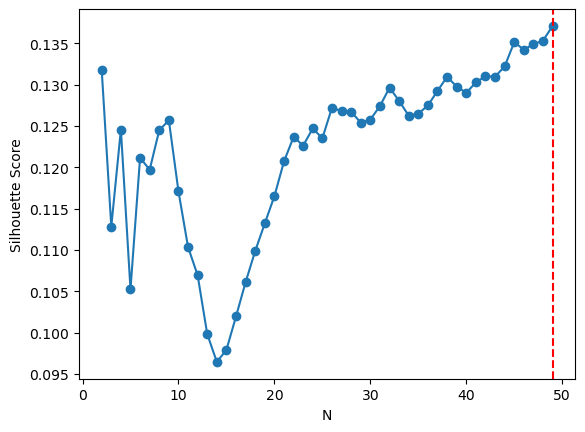

In [178]:
# Silhouette Scores (to find the best number of clusters)
sil_scores = []
n_range = range(2, 50)

# For each N
for n in n_range:
    # Save silhouette score on N
    prediction = AgglomerativeClustering(n_clusters = n, linkage = 'ward').fit_predict(scaled_df)
    sil_scores.append(silhouette_score(scaled_df, prediction))

# Determine N with the highest score
best_n_clusters = n_range[np.argmax(sil_scores)]
print(f'Optimal number of clusters (based on silhouette score): {best_n_clusters}')

# Plot results
plt.plot(n_range, sil_scores, marker = 'o')
plt.axvline(x = n_range[np.argmax(sil_scores)], color = 'red', linestyle = '--')
plt.xlabel('N')
plt.ylabel('Silhouette Score')
plt.show()

In [179]:
# Hierarchical clustering
best_n_clusters = 9
hcluster = AgglomerativeClustering(n_clusters = best_n_clusters, linkage = 'ward').fit(scaled_df)

In [180]:
#Showing distribution of cluster sizes
unique_clusters, counts = np.unique(hcluster.labels_, return_counts = True)

print("\nCluster Size Distribution:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} entries")


Cluster Size Distribution:
Cluster 0: 740 entries
Cluster 1: 500 entries
Cluster 2: 331 entries
Cluster 3: 264 entries
Cluster 4: 398 entries
Cluster 5: 460 entries
Cluster 6: 438 entries
Cluster 7: 17 entries
Cluster 8: 198 entries


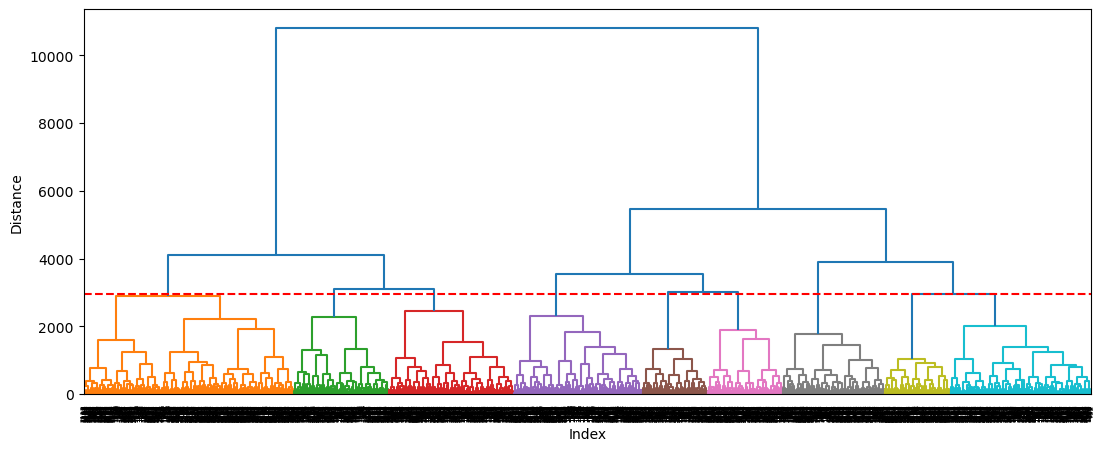

In [181]:
# Plotting the dendrogram and the cutoff line at the best merge distance
plt.figure(figsize = (13, 5))

link = linkage(df, method = 'ward')

# Distance just before forming best_n_clusters
best_merge_distance = link[-(best_n_clusters - 1), 2]

dendrogram(
    link,
    # labels = df['name'].values,
    color_threshold = best_merge_distance
)

# Plot a horizontal line at the best merge distance
plt.axhline(y = best_merge_distance, color = 'r', linestyle = '--')

plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()